# Selection function for a subset of the Gaia catalogue

The GaiaUnlimited module **subsample** provides a simple way of counting sources satisfying user-defined criteria, out of the whole Gaia catalogue. The result is given per bin of colour and magnitude, and per healpix region on the sky. The coulour and magnitude binning can be chosen by the user, as well as the spatial resolution (order of the healpix tessellation).

The method, along with other examples and code snippets, is presented in detail in Castro-Ginard et al. (2023):

https://ui.adsabs.harvard.edu/abs/2023arXiv230317738C/abstract

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt

from astroquery.gaia import Gaia

from gaiaunlimited import fetch_utils,utils
from gaiaunlimited import subsample            

In [2]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"

# Optional: authenticate with your Gaia archive credentials
# so the result of the query are stored online.
#Gaia.login(user='username', password='passwd')

Define dependencies of the selection function:
    
* healpix (required): desired resolution in the form of healpix level
* Gaia columns (optional): 
* 'name_of_column': [minimum value, maximum value, bin size]

In this example we make bins of 0.2 mag in **phot_g_mean_mag** and 0.4 mag in **g_rp**. We want the result in healpix regions of order 4.

In [3]:
inDict = {'healpix': 4,'phot_g_mean_mag': [3,20,0.2],'g_rp': [-2.5,5.1,0.4]}

Launch the query to the Gaia DR3 catalogue to determine which fraction of sources have a valid radial velocity (**radial_velocity is not null**). Depending on the exact query, this operation can take ~40 minutes.

The result will be stored locally in your **gaiaunlimited** folder (by default, .gaiaunlimited) as: **dr3_lvl4.csv**. If a file with this name is present, the module will read the local file instead of querying the Gaia archive.

This step can also take over half an hour to complete.

In [4]:
%%time
subsampleSF = subsample.SubsampleSelectionFunction(subsample_query = "radial_velocity is not null",\
                                         file_name = 'dr3_lvl4',hplevel_and_binning = inDict)

INFO: Query finished. [astroquery.utils.tap.core]
CPU times: user 1min 33s, sys: 4.56 s, total: 1min 37s
Wall time: 31min 14s


Now we want to visualise the results for the entire sky, so we generate a list of coordinates of the centers of all healpix regions of order 4.

For this plot we visualise the selection function at G=12 and G-RP=1.

The **.query()** method returns the posterior probability of a source satisfying the user-defined criteria, along with the associated variance. We visualise both:

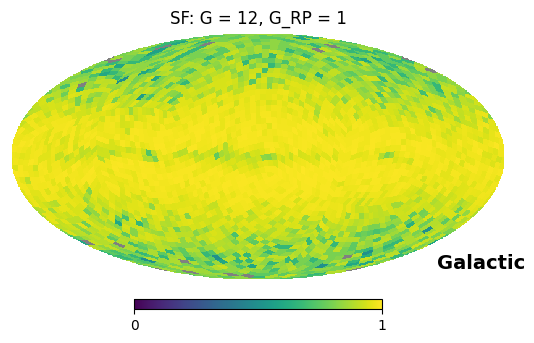

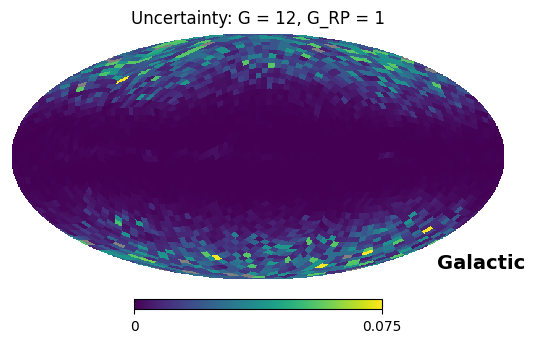

In [5]:
# Specify at which colour and magnitude
# you want to visualise the selection fraction:
G = 12
GRP = 1

coords_of_centers = utils.get_healpix_centers(4)
gmag = np.ones_like(coords_of_centers) * G
col = np.ones_like(coords_of_centers) * GRP

subsample_SF_lvl4,var_lvl4 = subsampleSF.query(coords_of_centers,phot_g_mean_mag_ = gmag,g_rp_ = col,
                                     return_variance = True,fill_nan = False)

plt.figure()
hp.mollview(subsample_SF_lvl4,hold = True,min = 0,max = 1,title = 'SF: G = {}, G_RP = {}'.format(G,GRP),coord = 'CG')

plt.figure()
hp.mollview(var_lvl4,hold = True,min = 0,title = 'Uncertainty: G = {}, G_RP = {}'.format(G,GRP),coord = 'CG')

## Selection function for a user-updated table (requires authenticated query)

Querying user tables can only be done in authenticated queries. If you do not already have a Gaia user account, you can create one here: https://www.cosmos.esa.int/web/gaia-users/register

Then log in:

In [ ]:
from astroquery.gaia import Gaia
Gaia.login(user='username', password='passwd')
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"

In this example we construct the selection function for the Gaia-Enceladus Sausage sample. In Castro-Ginard et al. (2023, Sect. 4) we reproduced the cuts from Helmi et al. (2018) and uploaded the table to the Gaia archive as:

    user_acastr01.ges_dr3
    
The task of matching sources and the binning and counting will be handled by the Gaia server. For this to work, the user table must contain a **source_id** column.

The selection function is then computed with:

In [ ]:
query_string = "source_id in (select source_id from user_acastr01.ges_dr3)"
inDict = {'healpix': 4,'phot_g_mean_mag': [3,20,0.2],'g_rp': [-2.5,5.1,0.4]}
userSampleSF = subsample.SubsampleSelectionFunction(subsample_query = query_string,
                                         file_name = 'userSample_lvl4',hplevel_and_binning = inDict)

which takes about 45 minutes to complete. The result can then be queried and displayed:

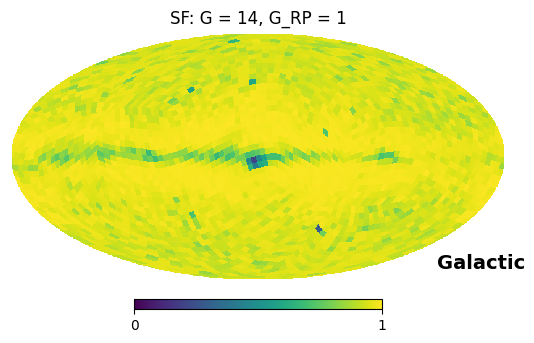

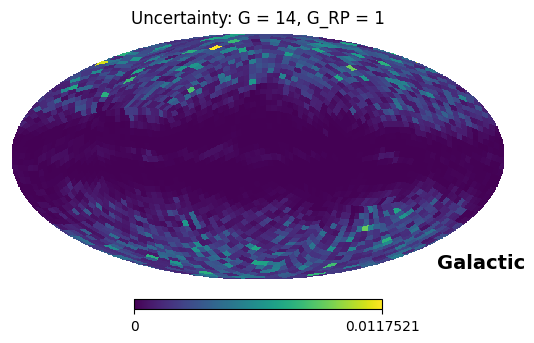

In [33]:
G = 14
GRP = 1

coords_of_centers = utils.get_healpix_centers(4)
gmag = np.ones_like(coords_of_centers) * G
col = np.ones_like(coords_of_centers) * GRP

userSample_SF_lvl4,userVar_lvl4 = subsampleSF.query(coords_of_centers,phot_g_mean_mag_ = gmag,g_rp_ = col,
                                     return_variance = True,fill_nan = False)

plt.figure()
hp.mollview(userSample_SF_lvl4,hold = True,min = 0,max = 1,
            title = 'SF: G = {}, G_RP = {}'.format(G,GRP),coord = 'CG')

plt.figure()
hp.mollview(userVar_lvl4,hold = True,min = 0,
            title = 'Uncertainty: G = {}, G_RP = {}'.format(G,GRP),coord = 'CG')